Hi, in this notebook we will show how to run StepFormer on UniVL video features to obtain step segmentation.
To convert extract UniVL features from your videos, please follow the instructions in SAIC-Toronto/UniVL-feat_extract github repository (by this [link](https://github.sec.samsung.net/SAIC-Toronto/UniVL-feat_extract))

In [4]:
import os, sys
import numpy as np
import torch

PROJECT_DIR = '/user/n.dvornik/Git/unsup-step-pred/'
sys.path.append(PROJECT_DIR)

from models.model_utils import load_last_checkpoint, get_decoder, compute_sim
from eval.video_segmentation import segment_video_into_slots
from dp.visualization import (color_code, shape_code, color_code_hex,
                              color_values, plot_step_to_video_alignment, plot_alignment,
                              plot_similarities, plot_gt_seg)
from config import CONFIG

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
dev = 'cpu'  # running everything on cpu

# setup config
transformer_name = "long"
output_folder = os.path.join(PROJECT_DIR, "outputs", transformer_name)
CONFIG.load(os.path.join(output_folder, "config.yml"))

# setup model
model = get_decoder()
load_last_checkpoint(transformer_name, model, 'cpu', remove_name_preffix="model.")
model.eval()

# setup video
univl_features_folder = "./samples"
videos = [np.load(f"{univl_features_folder}/{name}") for name in os.listdir(univl_features_folder)]

Loading checkpoint at /user/n.dvornik/Git/unsup-step-pred/weights/long/weights-epoch=78.ckpt


In [32]:
# let's take the first video for example. This video corresponds to this youtube link https://www.youtube.com/watch?v=jN6kowC-w0o
video_features = torch.tensor(videos[0])

# this parameter controls how much of steps and video frames we drop (higher -> more drop)
CONFIG.EVAL.FIXED_DROP_SIM = 0.44

# extract step slots with StepFormer
with torch.no_grad():
    steps = model(video_features[None, ...].to(dev)).to("cpu")[0]
    
step_segmentation = segment_video_into_slots(video_features, steps)

<module 'matplotlib.pyplot' from '/user/n.dvornik/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/pyplot.py'>

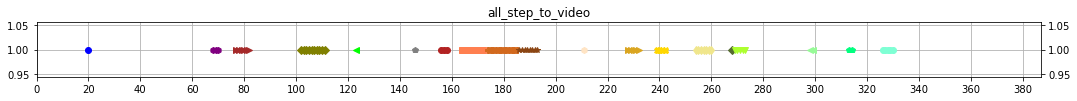

In [33]:
# let's visualize the obtained segmentation

new_ids = np.arange(steps.shape[0])
new_step_colors = {k + 1: color_code[k] for k in new_ids}
new_step_shapes = {k + 1: shape_code[k] for k in new_ids}
plot_alignment(new_ids + 1, step_segmentation, new_step_colors, new_step_shapes, size=(18, 1), to_np=False)

The above figure represents the timeline (the ticks on x axis correspond to seconds in the videos). 
Every colorerd segment corresponds to an instruction step detected with StepFormer